In [1]:
import json, os, pickle, random
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn

import qiskit
from qiskit import QuantumCircuit, execute
from qiskit.compiler import transpile
from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.quantum_info import SparsePauliOp, Operator
from qiskit.circuit.library import CXGate, RXGate, IGate, ZGate
from qiskit.providers.fake_provider import FakeMontreal, FakeLima

from utils import get_backend_properties_v1

# from blackwater.data.utils import (
#     generate_random_pauli_sum_op,
#     create_estimator_meas_data,
#     circuit_to_graph_data_json,
#     get_backend_properties_v1,
#     encode_pauli_sum_op,
#     create_meas_data_from_estimators
# )

from mlp import MLP1, MLP2, MLP3, encode_data

#from mbd_utils import cal_z_exp, generate_disorder, construct_mbl_circuit, calc_imbalance, modify_and_add_noise_to_model

import matplotlib.pyplot as plt
import seaborn as sns
from noise_utils import AddNoise, RemoveReadoutErrors

In [2]:
from mlp import recursive_dict_loop, count_gates_by_rotation_angle

In [3]:
from mbd_utils import calc_imbalance

In [4]:
def fix_random_seed(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    print(f'random seed fixed to {seed}')

In [5]:
backend = FakeLima()
properties = get_backend_properties_v1(backend)

## Local
backend_ideal = QasmSimulator() # Noiseless
backend_noisy = AerSimulator.from_backend(FakeLima()) # Noisy

run_config_ideal = {'shots': 10000, 'backend': backend_ideal, 'name': 'ideal'}
run_config_noisy = {'shots': 10000, 'backend': backend_noisy, 'name': 'noisy'}

In [6]:
backend = FakeLima()
properties = get_backend_properties_v1(backend)

# Local, coherent noise
backend_ideal = QasmSimulator() # Noiseless
backend_noisy_coherent, noise_model = AddNoise(backend=backend).add_coherent_noise(seed=0, theta=np.pi * 0.04, uniform=False, add_depolarization=True)

run_config_ideal = {'shots': 10000, 'backend': backend_ideal, 'name': 'ideal'}
run_config_noisy_coherent = {'shots': 10000, 'backend': backend_noisy_coherent, 'name': 'noisy_coherent'}

random seed fixed to 0
thetas [0.06896594 0.08987335 0.07574548 0.06847204 0.05323803 0.08116545
 0.05498883 0.1120635 ]


In [7]:
backend = FakeLima()
properties = get_backend_properties_v1(backend)

# Local, coherent noise
backend_ideal = QasmSimulator() # Noiseless
backend_noisy_no_readout = RemoveReadoutErrors().remove_readout_errors()[0]

run_config_ideal = {'shots': 10000, 'backend': backend_ideal, 'name': 'ideal'}

# no measurement errors 
run_config_noisy_no_readout = {'shots': 10000, 'backend': backend_noisy_no_readout, 'name': 'noisy_no_readout'}

num_qubit = 4

`load_circuits` loads the quantum circuit objects from the .pk files.

In [8]:
def load_circuits(data_dir, f_ext='.json'):
    circuits = []
    ideal_exp_vals = []
    noisy_exp_vals = []
    data_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(f_ext)]
    for data_file in tqdm(data_files[1:], leave=True):
        #print(data_file)
        if f_ext == '.json':
            for entry in json.load(open(data_file, 'r')):
                circuits.append(QuantumCircuit.from_qasm_str(entry['circuit']))
                ideal_exp_vals.append(entry['ideal_exp_value'])
                noisy_exp_vals.append(entry['noisy_exp_values'])
        elif f_ext == '.pk':
            for entry in pickle.load(open(data_file, 'rb')):
                circuits.append(entry['circuit'])
                ideal_exp_vals.append(entry['ideal_exp_value'])
                noisy_exp_vals.append(entry['noisy_exp_values'])
    return circuits, ideal_exp_vals, noisy_exp_vals

In [9]:
train_circuits, train_ideal_exp_vals, train_noisy_exp_vals_input = load_circuits('./data/ising_init_from_qasm_no_readout/train/', '.pk')
print(len(train_circuits))

test_circuits, test_ideal_exp_vals, test_noisy_exp_vals_input = load_circuits('./data/ising_init_from_qasm_no_readout/val/', '.pk')
print(len(test_circuits))

  0%|          | 0/14 [00:00<?, ?it/s]

4200


  0%|          | 0/14 [00:00<?, ?it/s]

1400


In [10]:
train_noisy_exp_vals = [x[0] for x in train_noisy_exp_vals_input]
test_noisy_exp_vals = [x[0] for x in test_noisy_exp_vals_input]

X_train, y_train = encode_data(train_circuits, properties, train_ideal_exp_vals, train_noisy_exp_vals, num_qubits=4)
X_test, y_test = encode_data(test_circuits, properties, test_ideal_exp_vals, test_noisy_exp_vals, num_qubits=4)

In [11]:
BATCH_SIZE = 32
fix_random_seed(42)
train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*1000, shuffle=False)

random seed fixed to 42


In [12]:
X_train = pd.DataFrame(X_train)#.iloc[:, -4:]
y_train = pd.DataFrame(y_train)
X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)

In [13]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
rfr_tree_list = []
for q in range(4):
    rfr = RandomForestRegressor(n_estimators=300)
    rfr.fit(X_train, y_train.iloc[:, q])
    rfr_tree_list.append(rfr)

random seed fixed to 0
RMSE_noisy_0: 0.06550247099813064
RMSE_mitigated_0: 0.024529022506254935
RMSE_noisy_1: 0.05991942535795197
RMSE_mitigated_1: 0.020082194883729424
RMSE_noisy_2: 0.1703969244030019
RMSE_mitigated_2: 0.03072809540396364
RMSE_noisy_3: 0.06290111600237397
RMSE_mitigated_3: 0.01762993283320405
RMSE_noisy: 0.101084832544792
RMSE_mitigated: 0.023769717474755706


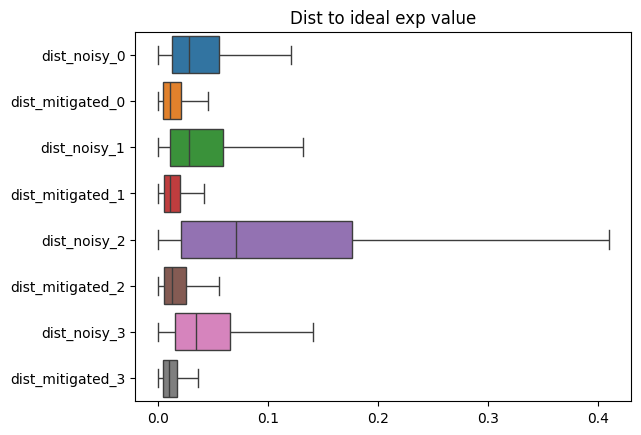

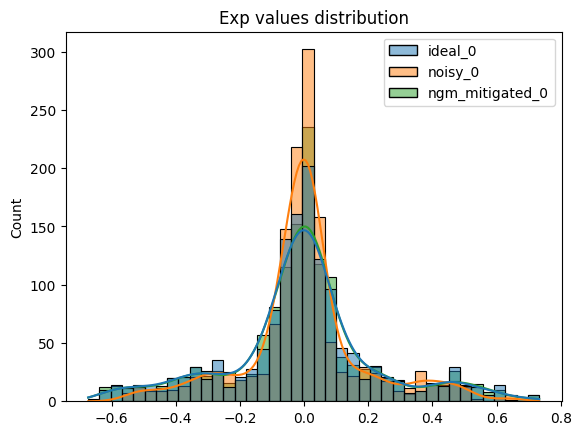

In [15]:
fix_random_seed(0)

distances = []

num_spins = 4
even_qubits = np.linspace(0, num_spins, int(num_spins/2), endpoint=False)
odd_qubits = np.linspace(1, num_spins+1, int(num_spins/2), endpoint=False)

for batch_X, batch_y in test_loader:
    out = []
    for q, model in enumerate(rfr_tree_list):
        out.append(model.predict(batch_X[:, :]))
    out = np.array(out).transpose()
    # out = rfr.predict(batch_X[:, -4:])

    for ideal, noisy, ngm_mitigated in zip(
        batch_y.tolist(),
        batch_X[:, -4:].tolist(),
        out.tolist()
    ):
        imbalance_ideal = calc_imbalance([ideal], even_qubits, odd_qubits)[0]
        imbalance_noisy = calc_imbalance([noisy], even_qubits, odd_qubits)[0]
        imbalance_mitigated = calc_imbalance([ngm_mitigated], even_qubits, odd_qubits)[0]
        for q in range(4):
            ideal_q = ideal[q]
            noisy_q = noisy[q]
            ngm_mitigated_q = ngm_mitigated[q]
            distances.append({
                f"ideal_{q}": ideal_q,
                f"noisy_{q}": noisy_q,
                f"ngm_mitigated_{q}": ngm_mitigated_q,
                f"dist_noisy_{q}": np.abs(ideal_q - noisy_q),
                f"dist_mitigated_{q}": np.abs(ideal_q - ngm_mitigated_q),
                f"dist_sq_noisy_{q}": np.square(ideal_q - noisy_q),
                f"dist_sq_mitigated_{q}": np.square(ideal_q - ngm_mitigated_q),
                "imb_ideal": imbalance_ideal,
                "imb_noisy": imbalance_noisy,
                "imb_ngm": imbalance_mitigated,
                "imb_diff": imbalance_ideal - imbalance_mitigated
            })

plt.style.use({'figure.facecolor':'white'})

df = pd.DataFrame(distances)

for q in range(4):
    print(f'RMSE_noisy_{q}:', np.sqrt(df[f"dist_sq_noisy_{q}"].mean()))
    print(f'RMSE_mitigated_{q}:', np.sqrt(df[f"dist_sq_mitigated_{q}"].mean()))

print(f'RMSE_noisy:', np.sqrt(np.mean([df[f"dist_sq_noisy_{q}"].mean() for q in range(4)])))
print(f'RMSE_mitigated:', np.sqrt(np.mean([df[f"dist_sq_mitigated_{q}"].mean() for q in range(4)])))

sns.boxplot(data=df[["dist_noisy_0", "dist_mitigated_0", "dist_noisy_1", "dist_mitigated_1", "dist_noisy_2", "dist_mitigated_2", "dist_noisy_3", "dist_mitigated_3"]], orient="h", showfliers = False)
plt.title("Dist to ideal exp value")
plt.show()

sns.histplot([df['ideal_0'], df['noisy_0'], df["ngm_mitigated_0"]], kde=True, bins=40)
plt.title("Exp values distribution")
plt.show()

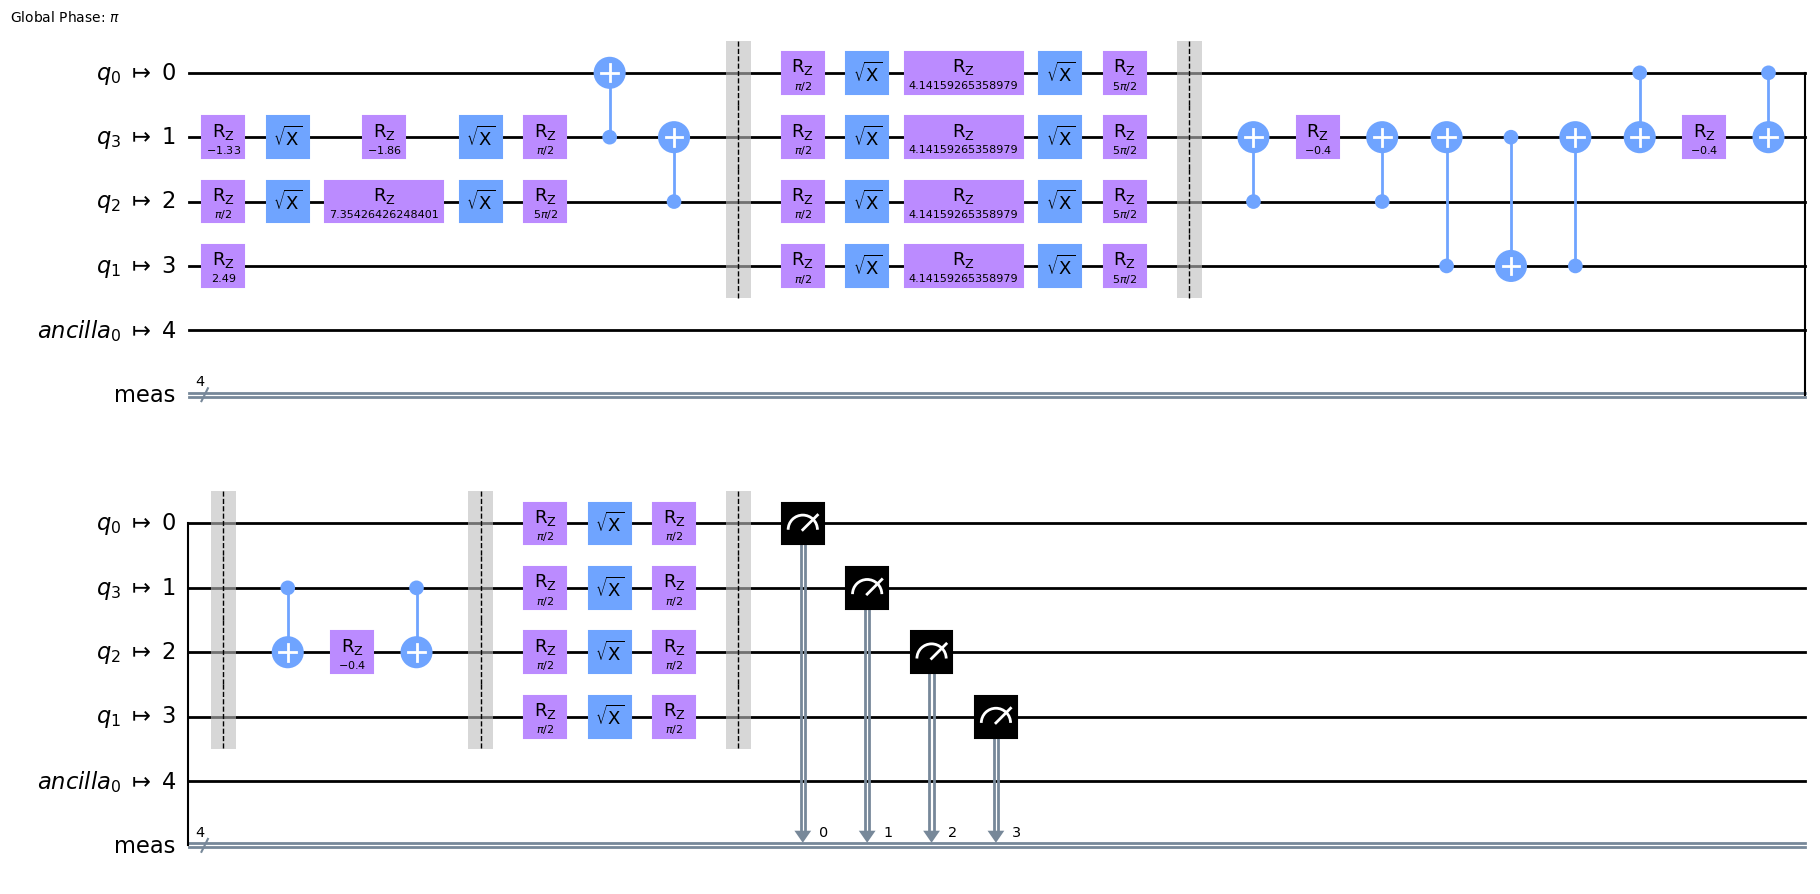

In [16]:
train_circuits[0].draw('mpl')

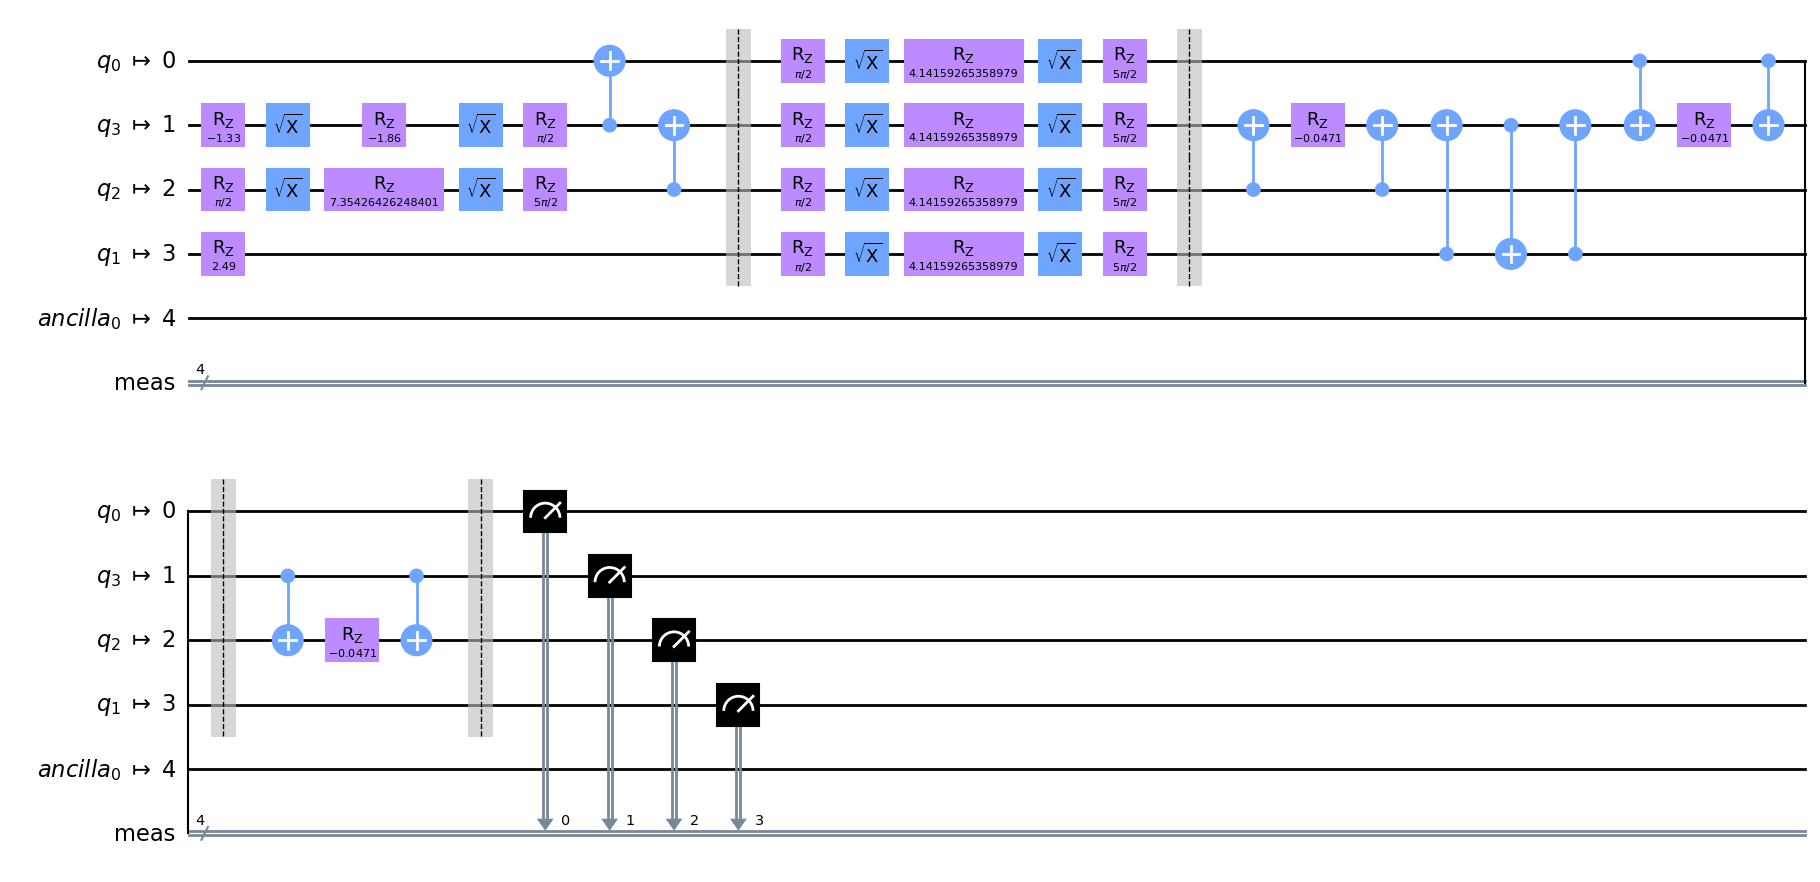

In [17]:
train_circuits[10].draw('mpl')

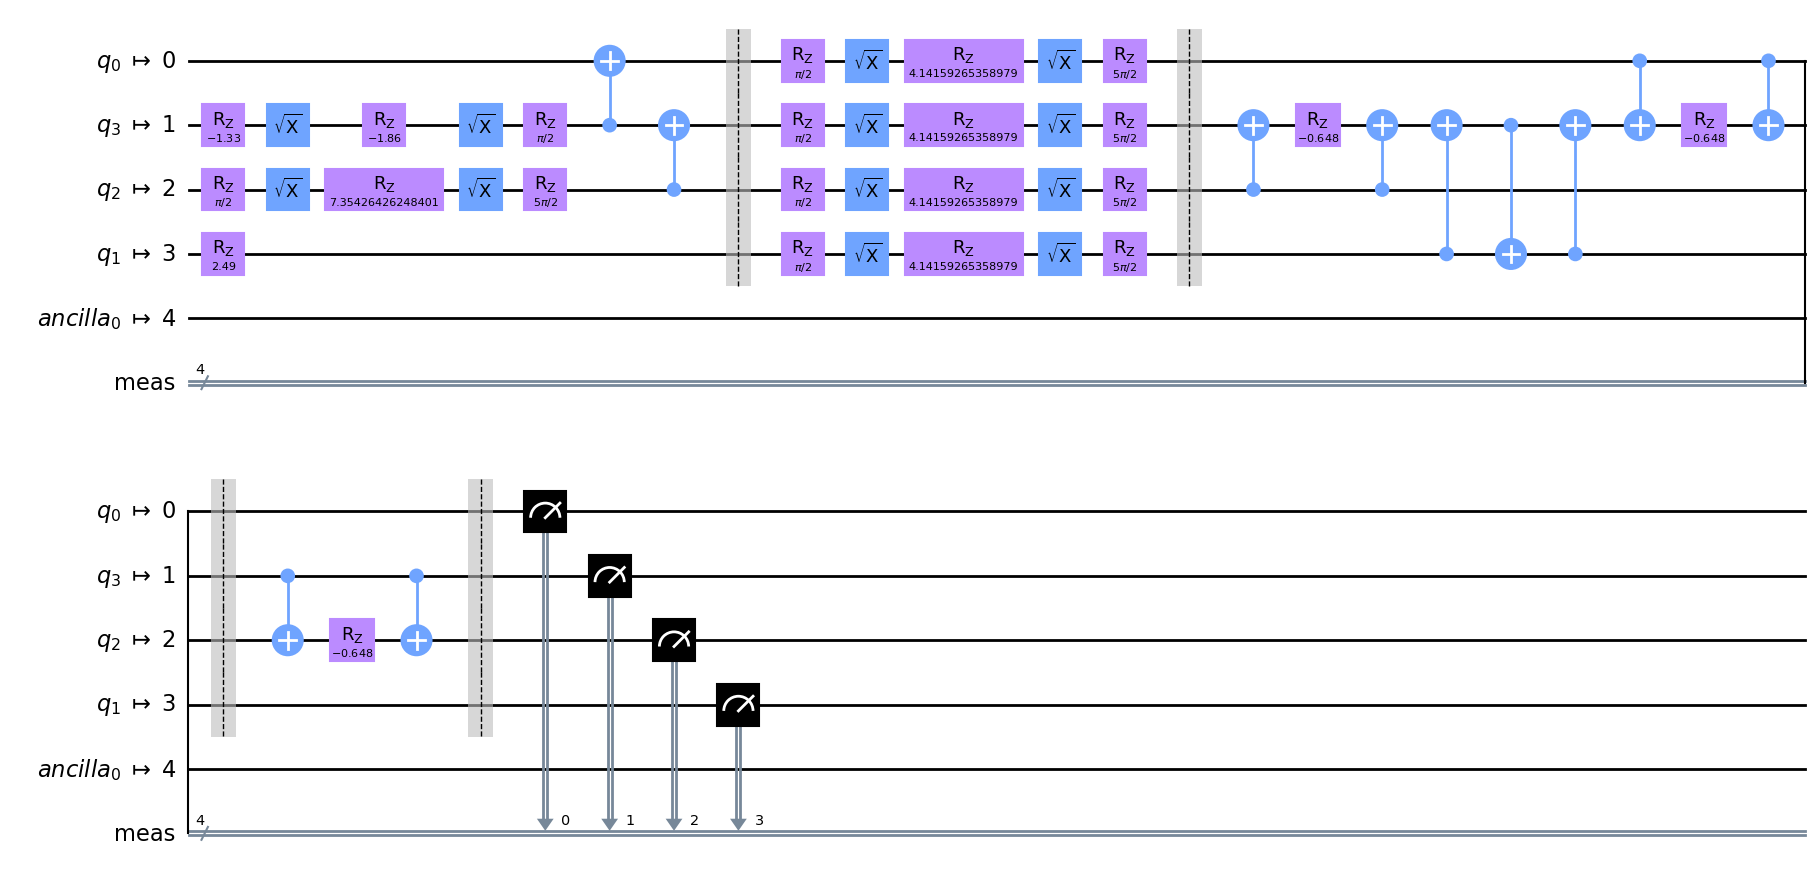

In [18]:
train_circuits[100].draw('mpl')

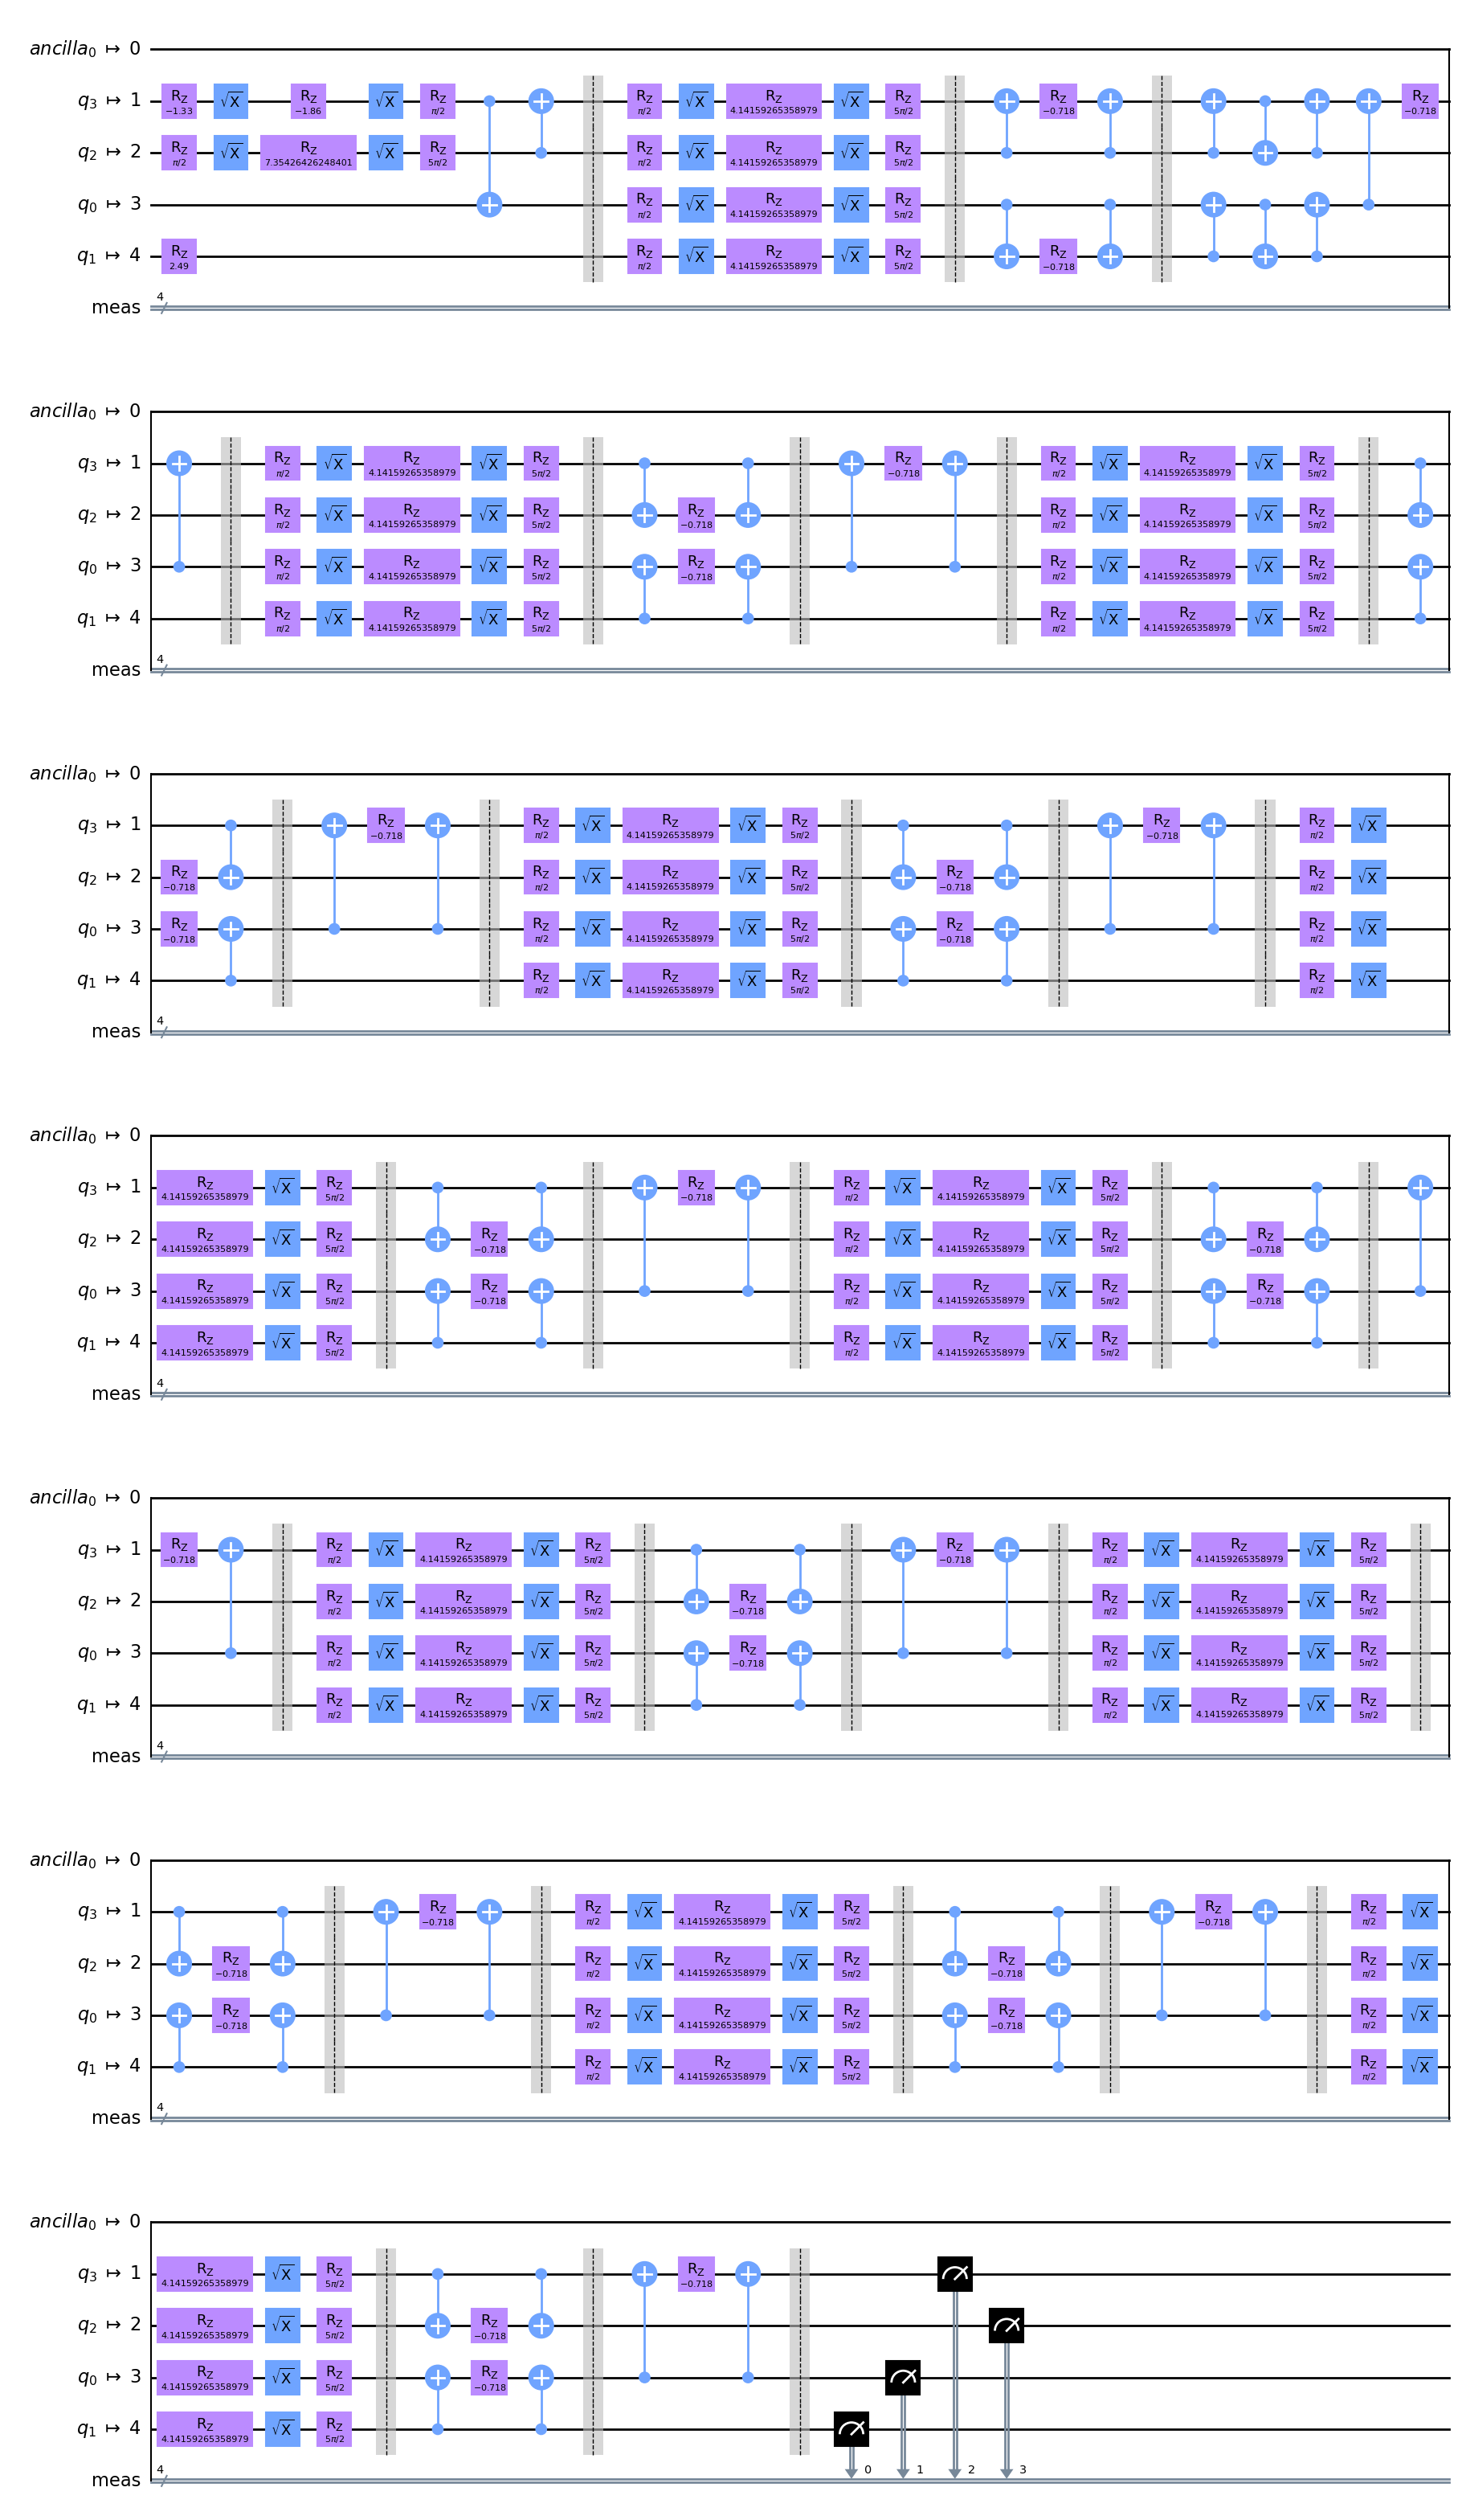

In [21]:
train_circuits[500].draw('mpl')

In [22]:
train_ideal_exp_vals[0]

[0.067, -0.0162, -0.0356, 0.0436]

In [23]:
train_ideal_exp_vals[10]

[0.0698, 0.2572, -0.5366, -0.1412]

In [24]:
train_ideal_exp_vals[100]

[0.0826, 0.2594, -0.5406, -0.1522]

In [25]:
train_ideal_exp_vals[200]

[0.0512, 0.0068, -0.0514, 0.0774]

In [26]:
train_noisy_exp_vals[0]

[0.057, -0.0024, -0.0276, 0.062]

In [27]:
train_noisy_exp_vals[10]

[0.067, 0.2144, -0.5272, -0.1518]

In [28]:
train_noisy_exp_vals[100]

[0.0446, 0.2504, -0.5252, -0.1752]

In [29]:
train_noisy_exp_vals[200]

[0.085, 0.0088, -0.031, 0.0642]

In [39]:
from qiskit import QuantumCircuit, Aer, transpile
from qiskit.providers.aer import StatevectorSimulator 
from qiskit.quantum_info import state_fidelity

qc1 = train_circuits[1]
qc2 = train_circuits[10]
simulator = Aer.get_backend('statevector_simulator') 
tqc1 = transpile(qc1, simulator) 
tqc2 = transpile(qc2, simulator) 
result1 = simulator.run(tqc1).result() 
result2 = simulator.run(tqc2).result() 
statevector1 = result1.get_statevector() 
statevector2 = result2.get_statevector()
fidelity = state_fidelity(statevector1, statevector2) 
print(f"Fidelity between the two quantum circuits: {fidelity}")
print(statevector1)
print(statevector2)

Fidelity between the two quantum circuits: 0.0
Statevector([ 0.       +0.j       ,  0.       +0.j       ,
              0.       +0.j       , -0.9825569+0.1859622j,
              0.       +0.j       ,  0.       +0.j       ,
              0.       +0.j       ,  0.       +0.j       ,
              0.       +0.j       ,  0.       +0.j       ,
              0.       +0.j       , -0.       +0.j       ,
             -0.       +0.j       ,  0.       +0.j       ,
              0.       +0.j       ,  0.       +0.j       ,
              0.       +0.j       ,  0.       +0.j       ,
              0.       +0.j       ,  0.       +0.j       ,
              0.       +0.j       ,  0.       +0.j       ,
              0.       +0.j       ,  0.       +0.j       ,
              0.       +0.j       ,  0.       +0.j       ,
              0.       +0.j       ,  0.       +0.j       ,
              0.       +0.j       ,  0.       +0.j       ,
              0.       +0.j       ,  0.       +0.j       ],
        